In [41]:
import joblib
import pandas as pd
import datetime as datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import base64 as b64
import requests

In [32]:
#Load liked track ids and all liked songs features from csv
liked_track_ids = joblib.load('Joblib_Objects/liked_track_ids')

liked_songs_df = pd.read_csv('liked_songs.csv',index_col=0)

#Load random songs csv
random_songs_df = pd.read_csv('random_songs.csv')
liked_songs_df

,track_id,genre,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,4f5nUYzeUioPwNbz2mGx5S,"['acid rock', 'album rock', 'blues rock', 'cla...",Jimi Hendrix,0.497,0.4990,9,-12.348,0,0.0560,0.05580,0.730000,0.2220,0.516,174.608
1,4kjJgdn53JuTLHvcedNAcl,['indie hip hop'],Phoelix,0.523,0.4210,7,-12.529,1,0.1330,0.60900,0.000859,0.3410,0.356,77.393
2,3U62bHMhP7bKAFYMkn3fNx,"['alternative r&b', 'electropop', 'etherpop', ...",Alina Baraz,0.679,0.5330,10,-8.454,1,0.0766,0.31300,0.033600,0.1710,0.521,83.502
3,44ashym52bERKclJsKt3Db,"['alternative r&b', 'indie hip hop', 'indie r&b']",Jordan Ward,0.894,0.4750,11,-8.346,1,0.1310,0.30900,0.000138,0.1110,0.571,144.202
4,2gEmgpnxseKEVRTwkSGopN,"['hip hop', 'rap']",Odd Future,0.510,0.0671,3,-12.163,0,0.0689,0.74400,0.000000,0.1660,0.197,106.017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
978,1Eolhana7nKHYpcYpdVcT5,"['acid rock', 'album rock', 'blues rock', 'cla...",Jimi Hendrix,0.515,0.5340,6,-8.045,1,0.0768,0.18100,0.002780,0.0547,0.426,70.776
979,0NWPxcsf5vdjdiFUI8NgkP,"['acid rock', 'album rock', 'blues rock', 'cla...",Jimi Hendrix,0.346,0.7680,9,-5.695,1,0.0377,0.00603,0.380000,0.0244,0.532,169.492
980,2aoo2jlRnM3A0NyLQqMN2f,"['acid rock', 'album rock', 'blues rock', 'cla...",Jimi Hendrix,0.438,0.8050,8,-6.237,1,0.0624,0.00255,0.000057,0.0842,0.564,113.253
981,36AlMHDBFwSsD3FQOy1R81,"['classic soul', 'funk', 'memphis soul', 'soul...",Otis Redding,0.587,0.1330,9,-15.151,0,0.0565,0.18600,0.000023,0.2580,0.068,102.938


In [28]:
#Format dataframe for model creation

#If song is from good songs playlist, this will define a favourite song (1 for favourite, 0 for non-favourite)
liked_songs_df['favourite'] = liked_songs_df['track_id'].map(lambda x: 1 if x in good_songs_track_ids else 0)

#Format genres to only have 1 listed
liked_songs_df['genre'] = liked_songs_df['genre'].map(lambda x: x.split('[')[1].split(']')[0].split(', ')[0].strip("'"))
liked_songs_df['genre'] = liked_songs_df['genre'].map(lambda x: 'Not Available' if x == '' else x)

In [29]:
#Drop track id and artist

liked_songs_df = liked_songs_df.drop(columns=['track_id','artist'])

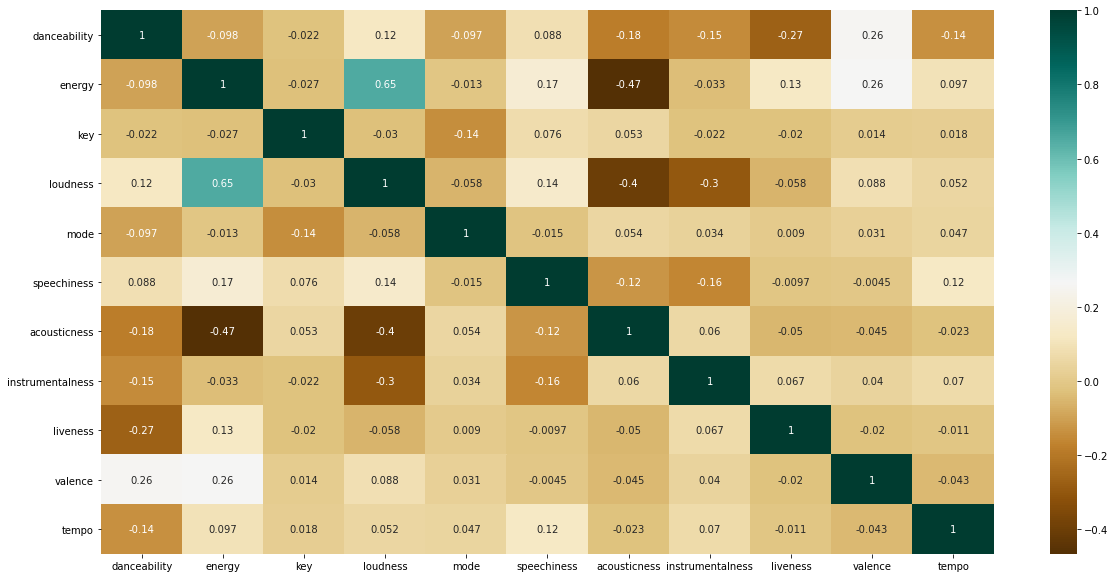

In [5]:
# Correlation Matrix of quantitative features
X = liked_songs_df.drop(columns='favourite')

plt.figure(figsize=(20,10))
c = X.corr()
corr = sns.heatmap(c,cmap="BrBG",annot=True)

In [6]:
#Label encode genres
from sklearn.preprocessing import LabelEncoder

genres_label_encoder = LabelEncoder()
genres = liked_songs_df['genre'].to_list()
genres_label_encoder.fit(genres)

liked_songs_df['genre'] = liked_songs_df['genre'].map(lambda x: genres_label_encoder.transform([x])[0])

#Dump LabelEncoder using joblib to be used when using model to determine if song is favourite
joblib.dump(genres_label_encoder,'Joblib_Objects/genres_label_encoder')
liked_songs_df

,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,favourite
0,1,0.497,0.4990,9,-12.348,0,0.0560,0.05580,0.730000,0.2220,0.516,174.608,0
1,64,0.523,0.4210,7,-12.529,1,0.1330,0.60900,0.000859,0.3410,0.356,77.393,0
2,10,0.679,0.5330,10,-8.454,1,0.0766,0.31300,0.033600,0.1710,0.521,83.502,0
3,10,0.894,0.4750,11,-8.346,1,0.1310,0.30900,0.000138,0.1110,0.571,144.202,1
4,60,0.510,0.0671,3,-12.163,0,0.0689,0.74400,0.000000,0.1660,0.197,106.017,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
978,1,0.515,0.5340,6,-8.045,1,0.0768,0.18100,0.002780,0.0547,0.426,70.776,0
979,1,0.346,0.7680,9,-5.695,1,0.0377,0.00603,0.380000,0.0244,0.532,169.492,0
980,1,0.438,0.8050,8,-6.237,1,0.0624,0.00255,0.000057,0.0842,0.564,113.253,0
981,38,0.587,0.1330,9,-15.151,0,0.0565,0.18600,0.000023,0.2580,0.068,102.938,0


In [7]:
#Split dataframe into X and y (features, and favourite)
X = liked_songs_df.drop(columns='favourite')
y = liked_songs_df['favourite']

#Scale values to remove bias in values
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

#Dump scaler using joblib
joblib.dump(scaler,'Joblib_Objects/scaler')

['Joblib_Objects/scaler']

In [8]:
#Check ratio of favourites to non-favourites
liked_songs_df['favourite'].value_counts()

0    680
1    303
Name: favourite, dtype: int64

In [13]:
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn import metrics 
from sklearn.metrics import f1_score
from scipy.stats import uniform, randint

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
import xgboost

In [14]:
# Train / Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = .20)

In [15]:
# Logistic Regression
lr = LogisticRegression()
lr_scores = cross_val_score(lr, X_train, y_train, cv=10, scoring="f1")
np.mean(lr_scores)

0.060485144485144485

In [16]:
# Hyperparameter optimization for Decision Tree Classifier
parameters = {
    'max_depth':[15,20,30],
}
dtc = Pipeline([('CV',GridSearchCV(DecisionTreeClassifier(), parameters, cv = 5))])
dtc.fit(X_train, y_train)
dtc.named_steps['CV'].best_params_

{'max_depth': 30}

In [18]:
# Decision Tree
dt = DecisionTreeClassifier(max_depth=30)
dt_scores = cross_val_score(dt, X_train, y_train, cv=10, scoring="f1")
np.mean(dt_scores)

0.34568698564625705

In [19]:
# Hyperparameter optimization of RandomForestClassifier
parameters = {
    'max_depth':[6,12,15,20],
    'n_estimators':[20,30]
}
clf = Pipeline([('CV',GridSearchCV(RandomForestClassifier(), parameters, cv = 5))])
clf.fit(X_train, y_train)
clf.named_steps['CV'].best_params_

{'max_depth': 6, 'n_estimators': 30}

In [20]:
# Cross-validation for RandomForestClassifier
rf = Pipeline([('rf', RandomForestClassifier(n_estimators = 20, max_depth = 30))])
rf_scores = cross_val_score(rf, X_train, y_train, cv=10, scoring="f1")
np.mean(rf_scores)

0.17848003083297198